In [61]:
# for calculating NDB score
# https://arxiv.org/pdf/1805.12462

In [62]:
import torchinfo
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from  torch.nn.functional import one_hot
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import copy
import os
from torchvision.models.feature_extraction import create_feature_extractor

In [63]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")
dtype = torch.double

%run /tigress/kendrab/analysis-notebooks/preproc_utils.ipynb
%run /tigress/kendrab/analysis-notebooks/torch_models/import_mms_data.ipynb

Using cpu device


### Default models

In [64]:
# determine necessary hyperparameters by looking at the log for that ADDA run
class MMSFeatExtract(nn.Module): #TODO: strided convolution instead of pooling?
    """ 1D CNN Model """
    def __init__(self, mms_num_conv, mms_kp_limit, mms_kernel_size, mms_pool_size, mms_out_channels, mms_learning_rate, mms_dropout_fraction, feat_shape):
        super().__init__()
        # define these all separately because they will get different weights
        # consider smooshing these together into one convolution with in_channels=6. Idk if a good idea
        feat_shape_nobatch = feat_shape[1:]
        self.bx_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(mms_out_channels, mms_kernel_size, padding='valid'),
                                           nn.LeakyReLU(), nn.AvgPool1d(mms_pool_size), nn.Dropout(p=mms_dropout_fraction)], mms_num_conv))
        self.by_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(mms_out_channels, mms_kernel_size, padding='valid'),
                                           nn.LeakyReLU(), nn.AvgPool1d(mms_pool_size), nn.Dropout(p=mms_dropout_fraction)], mms_num_conv))
        self.bz_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(mms_out_channels, mms_kernel_size, padding='valid'),
                                           nn.LeakyReLU(), nn.AvgPool1d(mms_pool_size), nn.Dropout(p=mms_dropout_fraction)], mms_num_conv))
        self.ex_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(mms_out_channels, mms_kernel_size, padding='valid'),
                                           nn.LeakyReLU(), nn.AvgPool1d(mms_pool_size), nn.Dropout(p=mms_dropout_fraction)], mms_num_conv))
        self.ey_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(mms_out_channels, mms_kernel_size, padding='valid'),
                                           nn.LeakyReLU(), nn.AvgPool1d(mms_pool_size), nn.Dropout(p=mms_dropout_fraction)], mms_num_conv))
        self.ez_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(mms_out_channels, mms_kernel_size, padding='valid'),
                                           nn.LeakyReLU(), nn.AvgPool1d(mms_pool_size), nn.Dropout(p=mms_dropout_fraction)], mms_num_conv))
        self.jy_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(mms_out_channels, mms_kernel_size, padding='valid'),
                                           nn.LeakyReLU(), nn.AvgPool1d(mms_pool_size), nn.Dropout(p=mms_dropout_fraction)], mms_num_conv))
        
        self.post_merge_layers = nn.Sequential(nn.Conv1d(mms_out_channels, mms_out_channels*2, mms_kernel_size,
                                                         padding='valid'),
                                               nn.LeakyReLU(),
                                               nn.AvgPool1d(mms_pool_size))
        self.resize_features = nn.Sequential(nn.Flatten(), nn.LazyLinear(np.prod(feat_shape_nobatch)), nn.Unflatten(-1, feat_shape_nobatch))
                                               

    def forward(self, bx, by, bz, ex, ey, ez, jy):
        bx_proc = self.bx_layers(bx)
        by_proc = self.by_layers(by)
        bz_proc = self.bz_layers(bz)
        ex_proc = self.ex_layers(ex)
        ey_proc = self.ey_layers(ey)
        ez_proc = self.ez_layers(ez)
        jy_proc = self.jy_layers(jy)
        combined = (bx_proc + by_proc + bz_proc + ex_proc + ey_proc + ez_proc + jy_proc)/6.
        mms_features = self.post_merge_layers(combined)
        features = self.resize_features(mms_features)
        
        return features

In [65]:
class MMSModel(nn.Module):
    def __init__(self, feat_extract, classifier):
        super().__init__()
        self.feat_extract = feat_extract
        self.classifier = classifier

    def forward(self, bx, by, bz, ex, ey, ez, jy):
        features = self.feat_extract(bx, by, bz, ex, ey, ez, jy)
        logits = self.classifier(features)
        return logits

### Helper functions

In [66]:
def n_samples_k_files(files, n, seed=98345093450793):
    # get n samples from k different files
    # return array of length len(files) of the number of samples from each file
    
    # construct probability dist for the files for uniform choice over the samples
    files_sizes = []
    
    for file in files:
        files_sizes.append(os.path.getsize(file))
    files_dist = np.array(files_sizes)/np.sum(files_sizes)
    
    sampler = default_rng(seed=seed)
    
    sample_names = sampler.choice(files, size=n, replace=True, p=files_dist)
    sample_freqs_tuple = np.unique(sample_names, return_counts=True)
    sample_freqs_dict = dict(zip(*sample_freqs_tuple))
   
    return sample_freqs_dict
    

In [ ]:
def get_mms_samples(full_mms_filenames, num_samples=10000, seed = 153925340):
    ''' splitting this part off of get_mms_features so we can access it separately
    dont always want to calc features right away'''
    mms_sample_counts = n_samples_k_files(full_mms_filenames, n=n)
    
    # get the samples
    samples_dict = {}
    sampler = default_rng(seed=seed)

    for file in full_mms_filenames:
        num_samples = mms_sample_counts.get(file, 0)  # if not specified assume 0 samples needed
        if num_samples == 0:  # taking no samples
            continue
        mms_data_dict = get_mms_data(file, folder="") 
        idxs_len = mms_data_dict['time'].shape[0]
        sample_idxs = sampler.choice(idxs_len, size=num_samples, replace=False)
        # slim down data to the chosen indices
        for label, data in mms_data_dict.items():
            samples = data[sample_idxs,...]
            if label not in samples_dict:
                samples_dict[label] = samples
            else:
                samples_dict[label] = np.concatenate([samples_dict[label], samples], axis=0)      
    
    return samples_dict

In [67]:
def get_mms_features(feature_extractor = None, seed = 60923507239, n = 10000, mms_data_loc = '/tigress/kendrab/analysis-notebooks/mms_data/mms_slices/',
                    mms_classifier_path = "/tigress/kendrab/analysis-notebooks/model_outs/20-09-24/adda_ndb190550_95mms_classifier_statedict.tar",
                    hyperparams = (1,9,3,4,40,0.0012094769607738786,0.03457536835651724,[11, 72, 3]), all_classifier = None):

    # set up the model
    if feature_extractor is None:  # use default
        if all_classifier is None:  # need to specify an all_classifier if using default model
            raise ValueError("feature_extractor and all_classifier cannot both be None, please specify one or the other.")
        feature_extractor = MMSFeatExtract(*hyperparams)  # yay magic hyperparameters
        mms_classifier = MMSModel(feature_extractor, all_classifier).to(device=device, dtype=dtype) 
        mms_classifier.load_state_dict(torch.load(mms_classifier_path))  # loads for feature_extractor too yayyyyy

    mms_filenames = get_filenames()
    full_mms_filenames = [mms_data_loc + filename for filename in mms_filenames]
    mms_sample_counts = n_samples_k_files(full_mms_filenames, n=n)        
        
    # get the samples
    samples_dict = {}
    sampler = default_rng(seed=seed)

    for file in full_mms_filenames:
        num_samples = mms_sample_counts.get(file, 0)  # if not specified assume 0 samples needed
        if num_samples == 0:  # taking no samples
            continue
        mms_data_dict = get_mms_data(file, folder="") 
        idxs_len = mms_data_dict['time'].shape[0]
        sample_idxs = sampler.choice(idxs_len, size=num_samples, replace=False)
        # slim down data to the chosen indices
        for label, data in mms_data_dict.items():
            samples = data[sample_idxs,...]
            if label not in samples_dict:
                samples_dict[label] = samples
            else:
                samples_dict[label] = np.concatenate([samples_dict[label], samples], axis=0)
                
    # get those featuressssssssssssssssss
    bx = torch.from_numpy(samples_dict['B'][:,0:1,:]).to(device, dtype=dtype)
    by = torch.from_numpy(samples_dict['B'][:,1:2,:]).to(device, dtype=dtype)
    bz = torch.from_numpy(samples_dict['B'][:,2:3,:]).to(device, dtype=dtype)
    ex = torch.from_numpy(samples_dict['E'][:,0:1,:]).to(device, dtype=dtype)
    ey = torch.from_numpy(samples_dict['E'][:,1:2,:]).to(device, dtype=dtype)
    ez = torch.from_numpy(samples_dict['E'][:,2:3,:]).to(device, dtype=dtype)
    jy = torch.from_numpy(samples_dict['j'][:,1:2,:]).to(device, dtype=dtype)
    features = feature_extractor.forward(bx, by, bz, ex, ey, ez, jy)
    
    return features, feature_extractor


In [68]:
def get_sim_models():  # this is mostly hard coded garbage specific to this one model but OH WELL
    %run /tigress/kendrab/analysis-notebooks/torch_models/import_model.ipynb
    sim_classifier = model.to(device=device, dtype=dtype)  # more illuminating name
    # extract the classifier and feature extractor parts
    return_nodes = {'post_merge_layers.2' : 'features'}
    feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)    
    all_classifier = nn.Sequential(*list(sim_classifier.children())[-1][-2:])
    models = {'feature_extractor':feature_extractor,'all_classifier':all_classifier}
    
    return models

In [69]:
def get_sim_features(feature_extractor = None, samples = None, n = 10000):
    # samples is a tensordataset with all the stuff in it
    # get feature extractor
    if feature_extractor is None:  # default
        feature_extractor = get_sim_models()['feature_extractor']
    # get samples
    if samples is None:
        %run /tigress/kendrab/analysis-notebooks/torch_models/import_sim_data.ipynb
        _, _, bx, by, bz, ex, ey, ez, jy, _, _, _ = next(iter(sim_dl))
    else:
        _, _, bx, by, bz, ex, ey, ez, jy, _, _, _ = samples
    # get features
    features = feature_extractor(bx, by, bz, ex, ey, ez, jy)
    
    return features

In [70]:
def kmeans_optimizing_plot(data, max_clusters=200, min_clusters=2, step=2, seed=1230958,
                    outfile="/tigress/kendrab/analysis-notebooks/model_outs/scratchwork/kmeans_silhouette.svg"):
    n_list = [i for i in range(min_clusters, max_clusters+1,step)]
    elbow_scores=[]
    silhouette_scores=[]
    for n_clusters in n_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto")
        kmeans.fit(data)
        elbow_scores.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data,kmeans.predict(data)))
    fig, ax = plt.subplots()
    ax.plot(n_list, silhouette_scores)    
    ax.set(title='Silhouette scores for k-means clustering', xlabel='number of clusters', ylabel='silhouette score')
    fig.tight_layout()
    fig.savefig(outfile)

In [71]:
def sample_prop(target_label, labels):
    P = np.sum(labels == target_label)/len(labels)
    return P

In [72]:
def P_standard_error(P_pooled, n_p, n_q):
    # as in the ndb paper, for pooled sample proportion P_pooled
    se = np.sqrt(P_pooled*(1 - P_pooled)*(1/n_p + 1/n_q))
    return se

In [73]:
def z_score(P_p, P_q, se):
    # pulled out for less typos hopefully
    z = np.abs(P_p - P_q)/se
    return z

In [74]:
def ndb_score(sim_features_flat, mms_features_flat, n_clusters=25, seed=1230958, threshold=1.96, kmeans_kwargs={'n_init':'auto'}):
    # calculate some things
    n_sim = sim_features_flat.shape[0]
    n_mms = mms_features_flat.shape[0]
    # get the predictions
    n_diff_bins = 0
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed, **kmeans_kwargs)
    sim_labels = kmeans.fit_predict(sim_features_flat)
    mms_labels = kmeans.predict(mms_features_flat)
    pooled_labels = np.concatenate([sim_labels, mms_labels])
    # calculate per bin z-score
    for bin_label in range(n_clusters):
        P_pooled = sample_prop(bin_label, pooled_labels)
        se = P_standard_error(P_pooled, n_sim, n_mms)
        P_sim = sample_prop(bin_label, sim_labels)
        P_mms = sample_prop(bin_label, mms_labels)
        print(P_sim, P_mms)
        z = z_score(P_sim, P_mms, se)
        if z > threshold:
            n_diff_bins +=1
            print(f"Bin number {bin_label} found statistically different "+
                  f"with z-score {z} > {threshold}")
        else:
            print(f"Bin number {bin_label} found statistically similar "+
                  f"with z-score {z} < {threshold}")
    score = n_diff_bins/n_clusters
    return score

### Main

/home/kendrab/.conda/envs/torch-env/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/kendrab/.conda/envs/torch-env/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(425291, 1, 89)
(425291, 2, 11)
torch.float64
torch.Size([10000, 72, 3])
torch.Size([10000, 72, 3])
torch.Size([10000, 216])
torch.Size([10000, 216])
Bin number 0 found statistically different with z-score 47.1535455582544 > 1.96
Bin number 1 found statistically different with z-score 25.75823366238392 > 1.96
Bin number 2 found statistically different with z-score 49.50980455410315 > 1.96
Bin number 3 found statistically different with z-score 127.30026172556371 > 1.96
Bin number 4 found statistically different with z-score 71.84692232688542 > 1.96
1.0


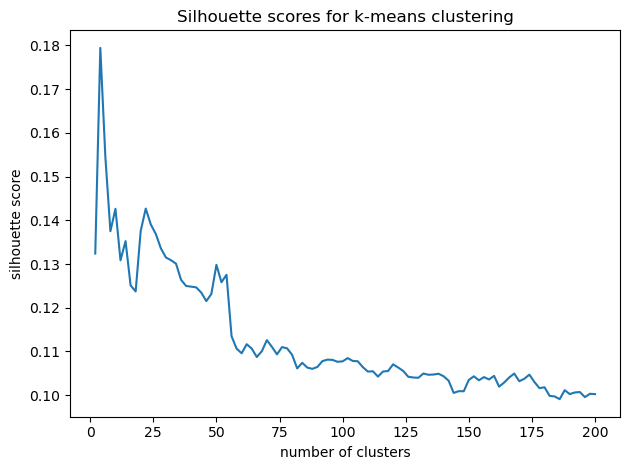

In [75]:
if __name__ == '__main__' and '__file__' not in globals():  # do not run if %run from another notebook
    n = 10000
    override_batch_size = True
    sim_models = get_sim_models()
    all_classifier = sim_models['all_classifier']

    mms_features, _ = get_mms_features(all_classifier=all_classifier, n=n, mms_classifier_path = "/tigress/kendrab/analysis-notebooks/model_outs/26-09-24/adda_ndb142201_0mms_classifier_statedict.tar")
    sim_features = get_sim_features(n=n)["features"]  # needed for get_feature_extractor case
    print(mms_features.shape)
    print(sim_features.shape)

    mms_features_flat = torch.flatten(mms_features, start_dim=1).detach()
    sim_features_flat = torch.flatten(sim_features, start_dim=1).detach()
    print(mms_features_flat.shape)
    print(sim_features_flat.shape)

    #### K-means cluster number optimizing

    # # look at knee plot to see how many clusters to use
    kmeans_optimizing_plot(sim_features_flat)

    #### NDB finding

    score = ndb_score(sim_features_flat, mms_features_flat, n_clusters=5, seed=62352358, threshold=1.96)
    print(score)